# Analysis of predictions of validation images

Import data:

1. Predicted class probabilities: df_pred_prob
2. Predicted class labels: df_pred_lbl
3. Ground truth labels: df_ground_truth

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
import cv2

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [13]:
df_train_v2 = pd.read_csv('../input/train.csv')

df_ground_truth = pd.read_csv('../results/xgb/xgb_ground_truths.csv')
df_pred_prob = pd.read_csv('../results/xgb/xgb_pred_probs.csv')
df_pred_label = pd.read_csv('../results/xgb/xgb_pred_lbls.csv')

columns = df_ground_truth.columns.values
columns[0]='img'
df_ground_truth.columns = columns
df_pred_prob.columns = columns
df_pred_label.columns = columns

df_text_ground_truth = (df_ground_truth==1)*(columns+',')
df_text_pred_label = (df_pred_label==1)*(columns+',')

index = df_ground_truth.index
df_tags_ground_truth = pd.DataFrame(index=index, columns=['img', 'tags'])
df_tags_ground_truth['img'] = df_ground_truth['img']
df_tags_ground_truth['tags'] = df_text_ground_truth.sum(axis=1) 

df_tags_pred_label = pd.DataFrame(index=index, columns=['img', 'tags'])
df_tags_pred_label['img'] = df_pred_label['img']
df_tags_pred_label['tags'] = df_text_pred_label.sum(axis=1) 
    
df_tags_pred_label.head()

img                                               tags
0    0                                haze,primary,clear,
1    1  img,agriculture,cultivation,road,primary,water...
2    2                                     primary,clear,
3    3                                     primary,clear,
4    4  agriculture,cultivation,primary,habitation,wat...

Calculations:

 - Predicted labels match groundtruth, where groundtruth label=1: df_match
 - Fraction of matched labels, where groundtruth label=1: fraction_match

In [14]:
df_positive = df_ground_truth > 0
df_negative = df_ground_truth == 0
df_match = df_positive * (df_pred_label == 1)
df_mismatch = df_negative * (df_pred_label == 1)
sum_positive = df_positive.sum(axis=0)
sum_match = df_match.sum(axis=0)
sum_negative = df_negative.sum(axis=0)
sum_mismatch = df_mismatch.sum(axis=0)
fraction_match = sum_match  / sum_positive
fraction_match = fraction_match[1:]

df_sum = pd.DataFrame([sum_positive,sum_match,sum_mismatch], index=['nr in ground truth', 'nr of matches', 'nr of mismatches'])
df_sum = df_sum.T[1:]
df_sum

/home/alejandro/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead



nr in ground truth  nr of matches  nr of mismatches
blooming                          332             21                90
partly_cloudy                    7261           6677              2323
agriculture                     12315          11440              7450
conventional_mine                 100             10                 9
cultivation                      4477           2721              4497
haze                             2697           2175              2019
road                             8071           6903              6103
cloudy                           2089           1833               849
primary                         37513          37387              1727
artisinal_mine                    339            201               156
habitation                       3660           2727              2683
slash_burn                        209              4                 9
water                            7411           6844             16917
selective_logging                 340             24                94
bare_ground                       862            164               327
clear                           28431          28146              3307
blow_down                          98              3                 8

Plot number of matched labels per class.

Conclusions: 
- forget about blow_down, bare_ground, conventional_mine, artisinial_mine, slash_burn, selective_logging
- focus on overpredictions of cultivation, road, agriculture, water

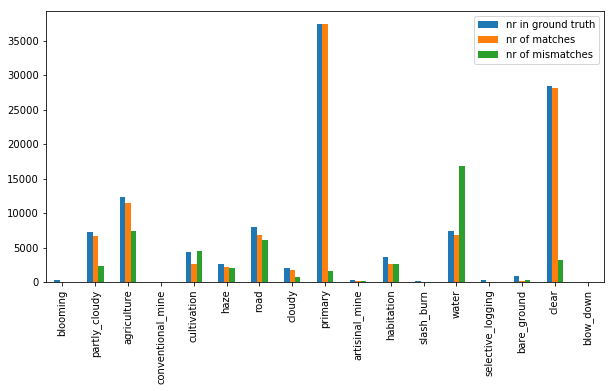

In [15]:
df_sum.plot(kind='bar', figsize=(10, 5))

Correlation matrices between tags in both the ground truth and the predicted labels.

Conclusions:
 - postprocess submission: if 'cloudy'== 1, then set all other tags=0

In [16]:
tags = columns[1:]

np_ground_truth = df_ground_truth.drop('img', axis=1).as_matrix().astype(np.float32)
np_pred_label = df_pred_label.drop('img', axis=1).as_matrix().astype(np.float32)
# Co-occurence Matrices
com_ground_truth = np.zeros([len(tags)]*2)
for l, tag in enumerate(tags):
        for l2, tag2 in enumerate(tags):
            if np_ground_truth[:,l].sum()>0:
                com_ground_truth[l, l2] = np_ground_truth[:,l].dot(np_ground_truth[:,l2])/np_ground_truth[:,l].sum()
            else:
                com_ground_truth[l, l2] = 0
com_pred_label = np.zeros([len(tags)]*2)
for l, tag in enumerate(tags):
        for l2, tag2 in enumerate(tags):
            if np_pred_label[:,l].sum()>0:
                com_pred_label[l, l2] = np_pred_label[:,l].dot(np_pred_label[:,l2])/np_pred_label[:,l].sum()
            else:
                com_pred_label[l, l2] = 0
com_diff = com_pred_label - com_ground_truth
com_perc = np.clip(com_diff / np.clip(com_ground_truth, 0.01, None), 0, 5)

# Plotting
data=go.Heatmap(z=com_ground_truth, x=list(tags), y=list(tags))
#layout=go.Layout(autosize=False, height=400, width=400, title='Co-occurence matrix of ground truth labels')
data2=go.Heatmap(z=com_pred_label, x=list(tags), y=list(tags))
#layout2=go.Layout(autosize=False, height=400, width=400, title='Co-occurence matrix of predicted labels')
data3=go.Heatmap(z=com_diff, x=list(tags), y=list(tags))
data4=go.Heatmap(z=com_perc, x=list(tags), y=list(tags))

fig = tls.make_subplots(rows=1, cols=2, subplot_titles=('Ground truth labels','Predicted labels'))

fig.append_trace(data, 1, 1)
fig.append_trace(data2, 1, 2)
py.iplot(fig)

fig = tls.make_subplots(rows=1, cols=2, subplot_titles=('Difference','Percentage difference'))
fig.append_trace(data3, 1, 1)
fig.append_trace(data4, 1, 2)
py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



Plot misclassified images to find clues why they were misclassified.

Cloudy should be easy, so checking those first. Multiple weather classes are predicted, while there can be only one per image.
First images that were wrongly labeled as 'cloudy'.

Number of images = 849


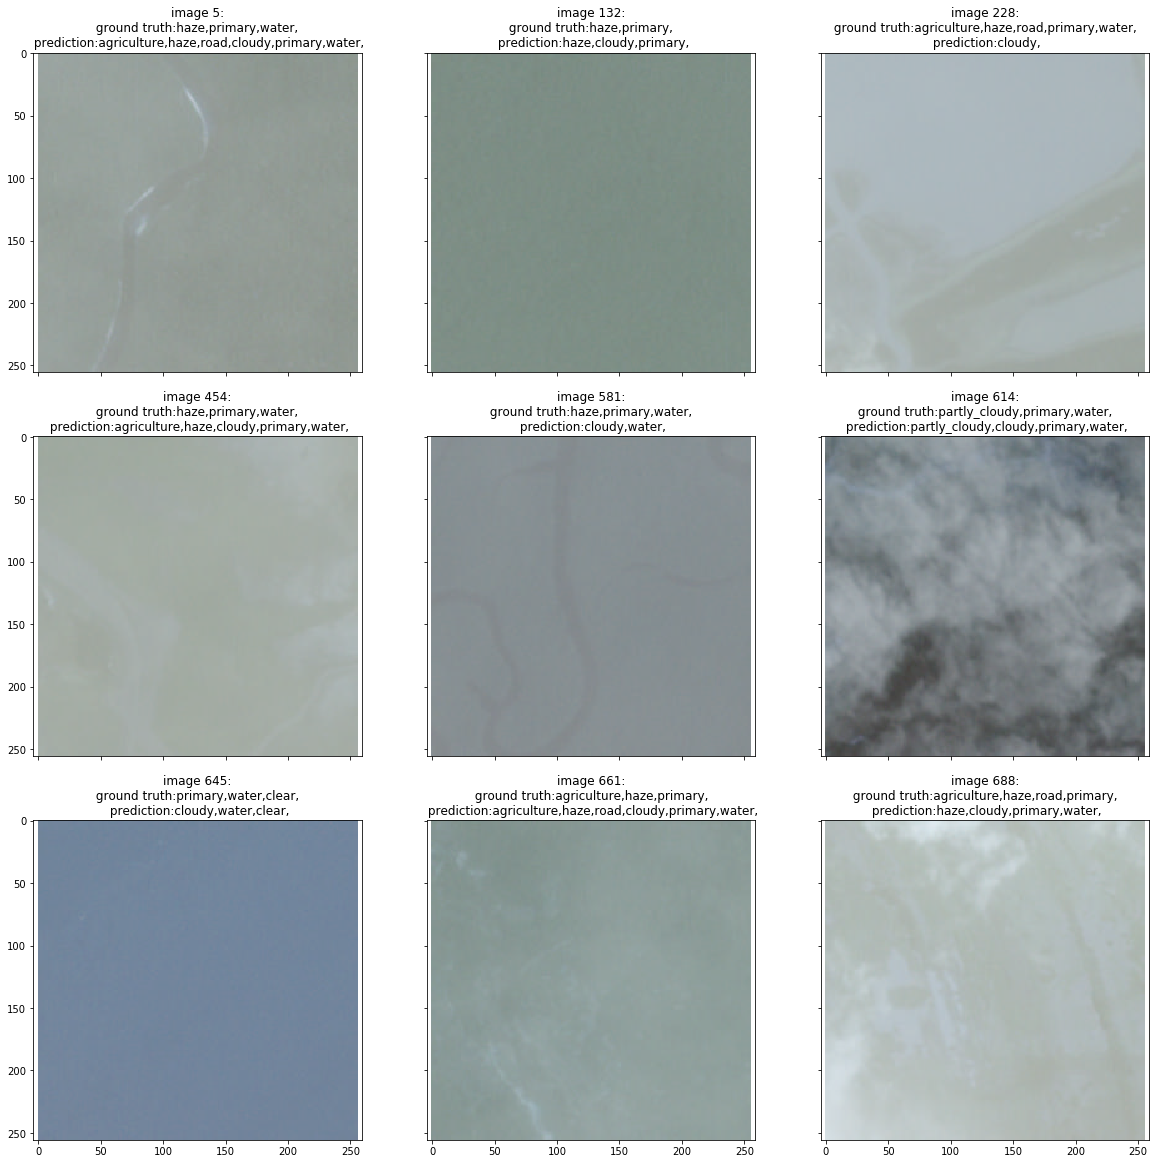

In [18]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))

label = 'cloudy'

i = 0
for f in df_match.index:
    #if df_pred_label[label][f]==0 and df_ground_truth[label][f]==1:
    if df_pred_label[label][f]==1 and df_ground_truth[label][f]==0:
        if i < 9:
            l = df_ground_truth['img'][f]
            img = io.imread('../input/train-jpg/train_{}.jpg'.format(l))
            #img = io.imread('../input/train-tif-v2/train_{}.tif'.format(f))
            ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax[i // 3, i % 3].set_title('image {}:\n ground truth:{} \n prediction:{}'.format(l, df_tags_ground_truth['tags'][f], df_tags_pred_label['tags'][f]))
            #ax[i // 4, i % 4].show()
        i += 1
    
print("Number of images = {}".format(i))
plt.show()

Then images that were wrongly labeled as not 'cloudy'.

Number of images = 256


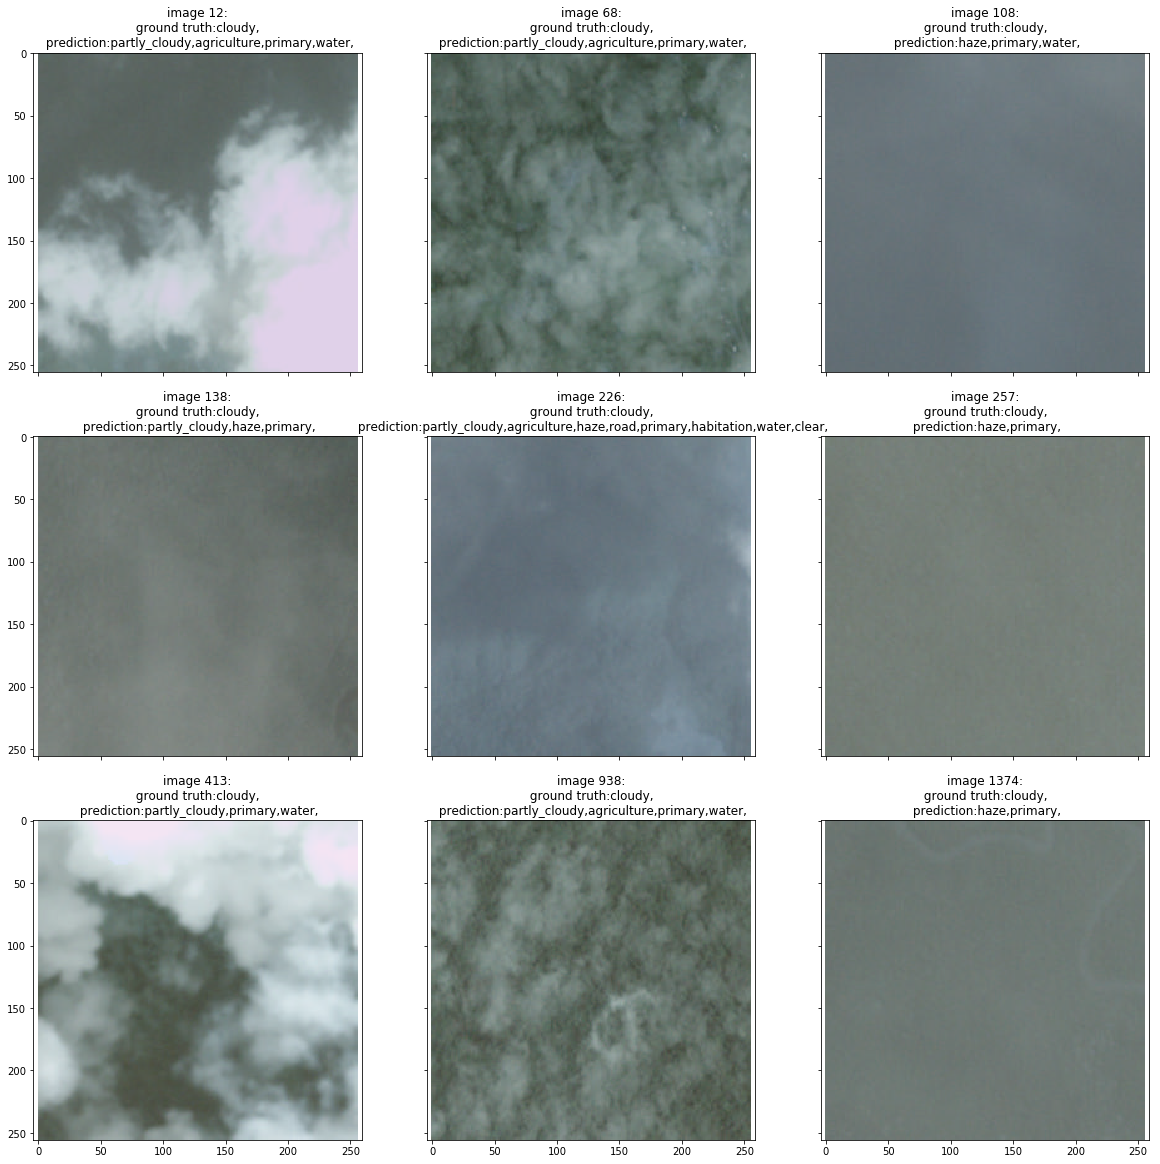

In [21]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))

label = 'cloudy'

i = 0
for f in df_match.index:
    if df_pred_label[label][f]==0 and df_ground_truth[label][f]==1:
    #if df_pred_label[label][f]==1 and df_ground_truth[label][f]==0:
        if i < 9:
            l = df_ground_truth['img'][f]
            img = io.imread('../input/train-jpg/train_{}.jpg'.format(l))
            #img = io.imread('../input/train-tif-v2/train_{}.tif'.format(f))
            ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax[i // 3, i % 3].set_title('image {}:\n ground truth:{} \n prediction:{}'.format(l, df_tags_ground_truth['tags'][f], df_tags_pred_label['tags'][f]))
            #ax[i // 4, i % 4].show()
        i += 1
        
print("Number of images = {}".format(i))    
plt.show()

Water seems to be difficult, mismatches below look hard indeed.

Number of images = 16917


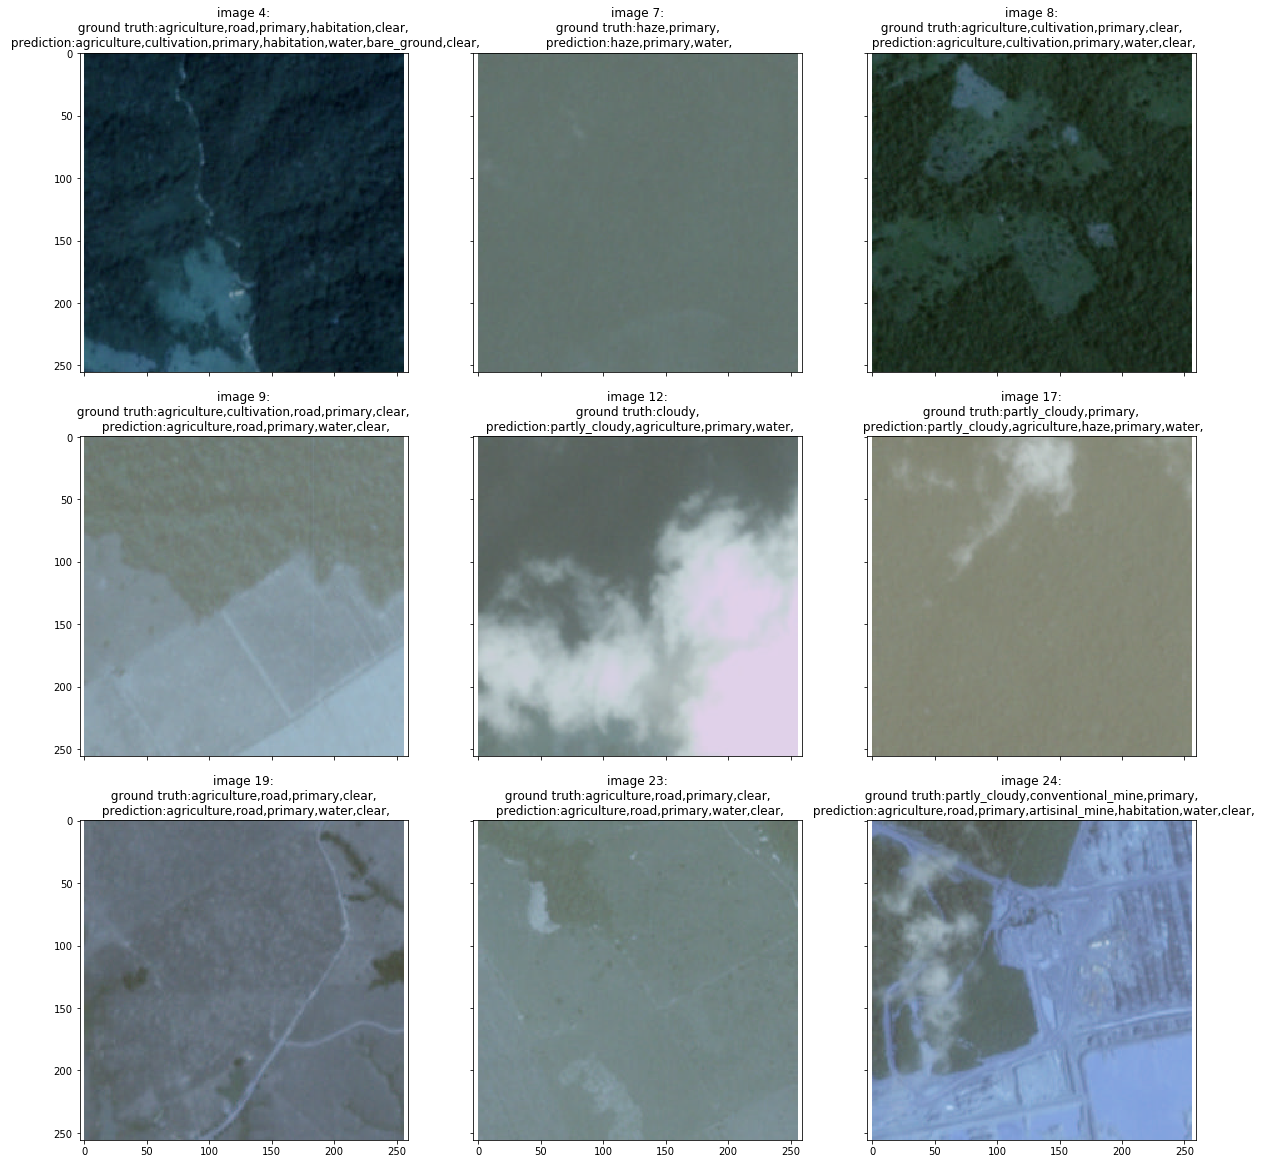

In [23]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))

label = 'water'

i = 0
for f in df_match.index:
    #if df_pred_label[label][f]==0 and df_ground_truth[label][f]==1:
    if df_pred_label[label][f]==1 and df_ground_truth[label][f]==0:
        if i < 9:
            l = df_ground_truth['img'][f]
            img = io.imread('../input/train-jpg/train_{}.jpg'.format(l))
            #img = io.imread('../input/train-tif-v2/train_{}.tif'.format(f))
            ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax[i // 3, i % 3].set_title('image {}:\n ground truth:{} \n prediction:{}'.format(l, df_tags_ground_truth['tags'][f], df_tags_pred_label['tags'][f]))
            #ax[i // 4, i % 4].show()
        i += 1
        
print("Number of images = {}".format(i))    
plt.show()

Check misclassified roads. If they are often waterways then a higher resolutiona with the IR signal may help. 

Number of images = 6103


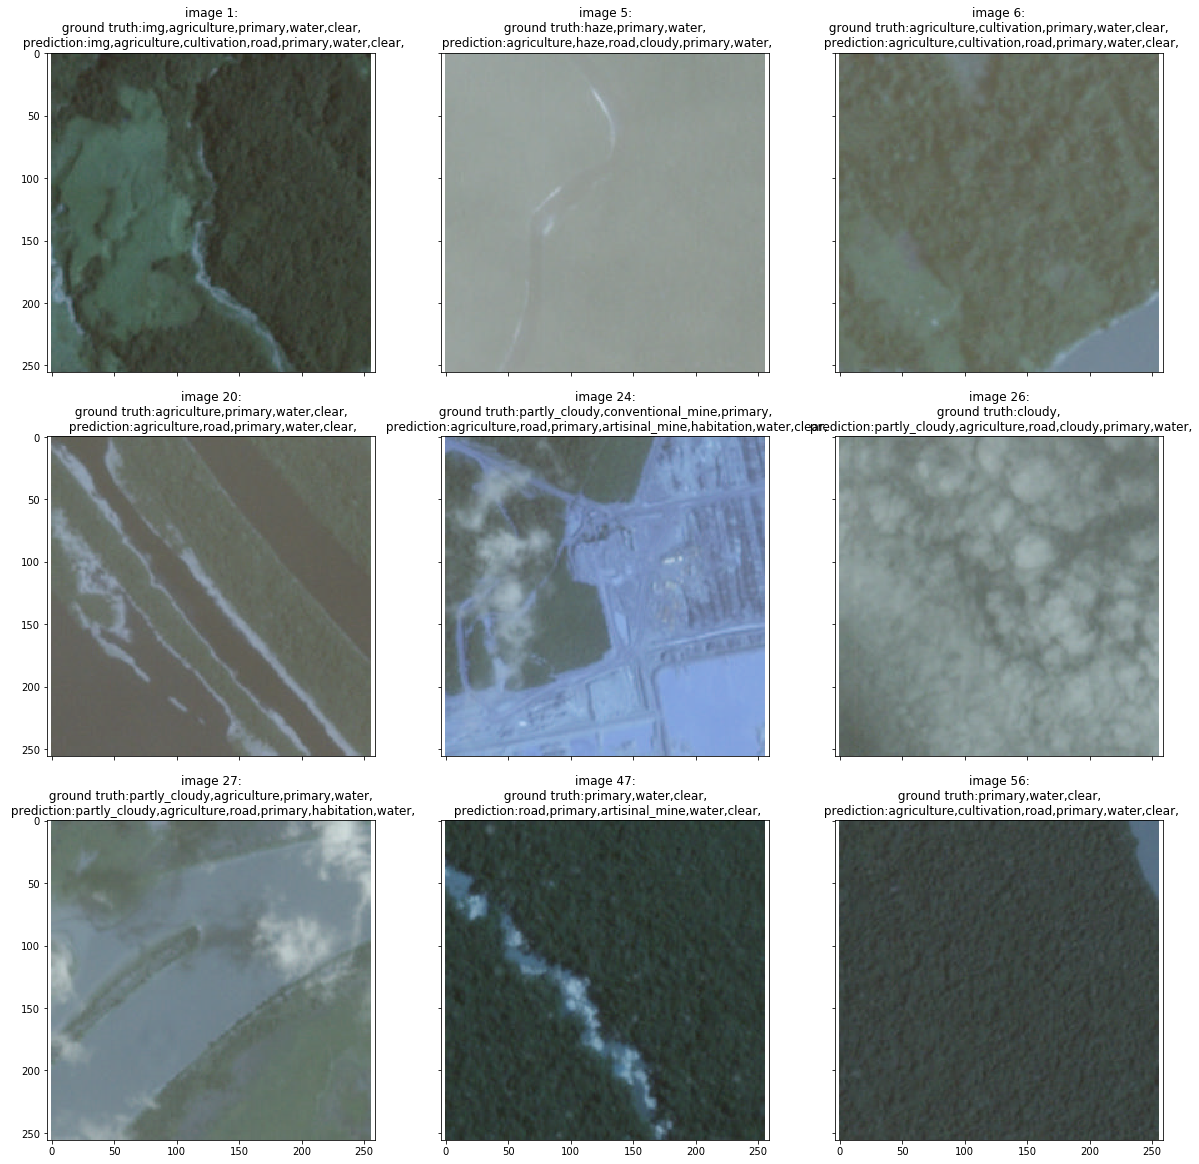

In [24]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))

label = 'road'

i = 0
for f in df_match.index:
    #if df_pred_label[label][f]==0 and df_ground_truth[label][f]==1:
    if df_pred_label[label][f]==1 and df_ground_truth[label][f]==0:
        if i < 9:
            l = df_ground_truth['img'][f]
            img = io.imread('../input/train-jpg/train_{}.jpg'.format(l))
            #img = io.imread('../input/train-tif-v2/train_{}.tif'.format(f))
            ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax[i // 3, i % 3].set_title('image {}:\n ground truth:{} \n prediction:{}'.format(l, df_tags_ground_truth['tags'][f], df_tags_pred_label['tags'][f]))
            #ax[i // 4, i % 4].show()
        i += 1

print("Number of images = {}".format(i))
plt.show()

Number of images = 5


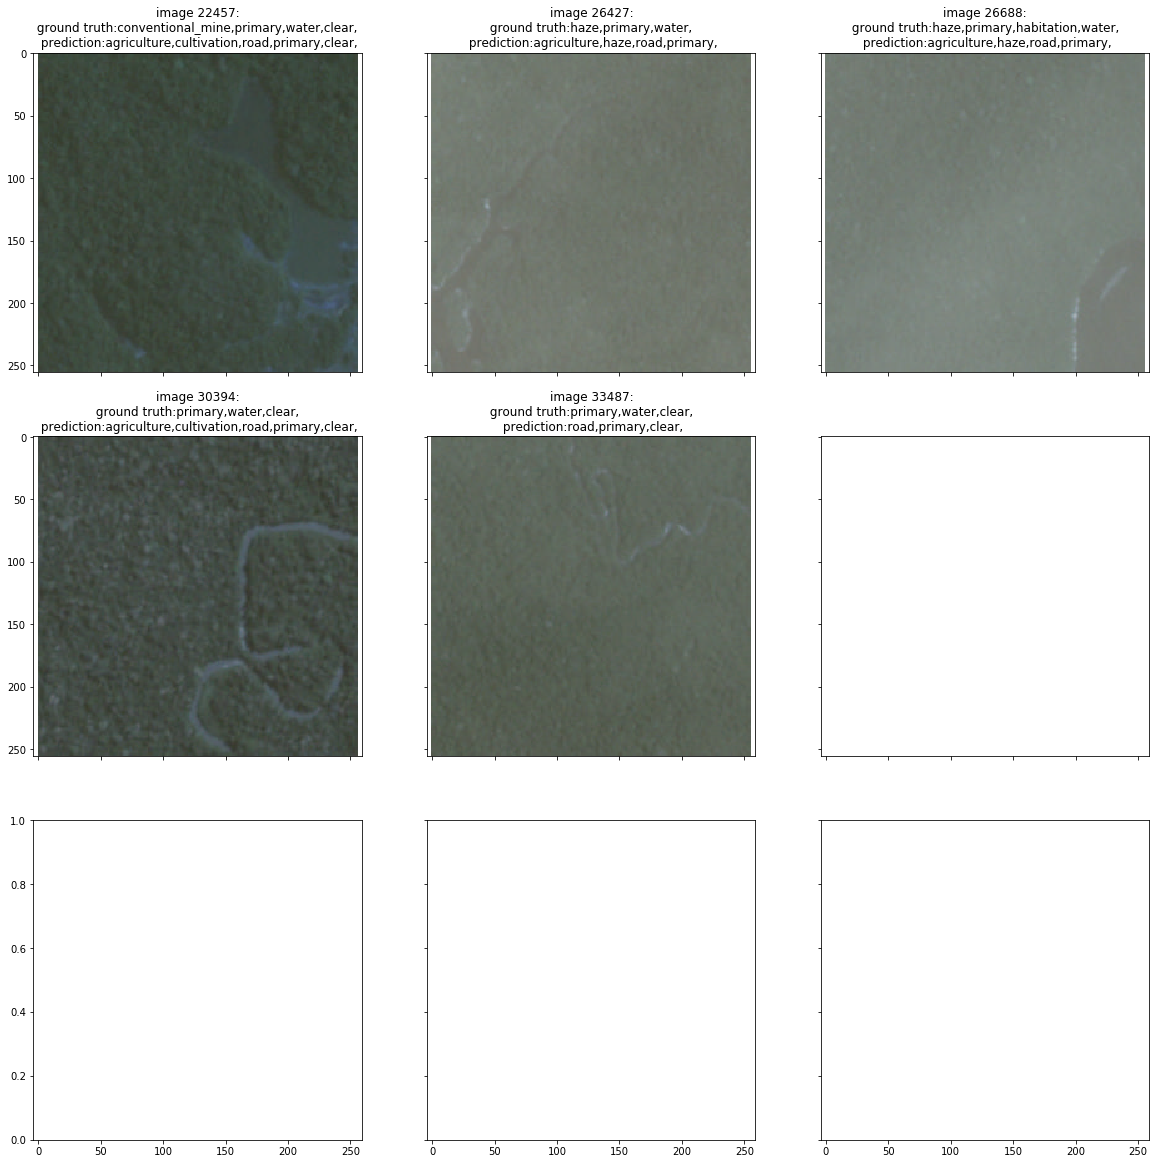

In [25]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))

label1 = 'road'
label2 = 'water'

i = 0
for f in df_match.index:
    #if df_pred_label[label][f]==0 and df_ground_truth[label][f]==1:
    if df_pred_label[label1][f]==1 and df_pred_label[label2][f]==0 \
    and df_ground_truth[label1][f]==0 and df_ground_truth[label2][f]==1:
        if i < 9:
            l = df_ground_truth['img'][f]
            img = io.imread('../input/train-jpg/train_{}.jpg'.format(l))
            #img = io.imread('../input/train-tif-v2/train_{}.tif'.format(f))
            ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax[i // 3, i % 3].set_title('image {}:\n ground truth:{} \n prediction:{}'.format(l, df_tags_ground_truth['tags'][f], df_tags_pred_label['tags'][f]))
            #ax[i // 4, i % 4].show()
        i += 1

print("Number of images = {}".format(i))
plt.show()